In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
!pip3 install seaborn

    100% |████████████████████████████████| 215kB 14.9MB/s ta 0:00:01
You are using pip version 19.0.3, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
%autoreload 2
from utils import *

import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import os
import lightgbm as lgbm
import warnings
from utils import *
import seaborn as sns
from sklearn.metrics import accuracy_score
from parameters import top_tickers, ibkr_info

sns.set()

warnings.filterwarnings('ignore')

In [8]:
np.array(list(ibkr_info.keys()))

array(['RNFT', 'PHOR', 'CBOM', 'POLY', 'TATNP', 'RTKM', 'PLZL', 'DSKY',
       'SFIN', 'IRAO', 'HYDR', 'RUAL', 'SNGSP', 'LKOH', 'MTLR', 'CHMF',
       'MVID', 'TATN', 'ALRS', 'MTSS', 'MGNT', 'NLMK', 'GAZP', 'GMKN',
       'YNDX', 'AFLT', 'AFKS', 'TRMK', 'MAGN', 'SNGS', 'FIVE', 'PIKK',
       'FEES', 'MOEX'], dtype='<U5')

In [3]:
load_tickers(data_prefix="data/train", tickers=np.array(list(ibkr_info.keys())), start_date=datetime.strptime("20170101", "%Y%m%d").date(), end_date=datetime.today().date() + timedelta(days=1), period=3)

 12%|█▏        | 5/41 [01:01<07:22, 12.29s/it]

DSKY


 17%|█▋        | 7/41 [01:15<06:01, 10.64s/it]

FIVE


 61%|██████    | 25/41 [04:44<02:58, 11.17s/it]

RNFT


 76%|███████▌  | 31/41 [05:50<02:04, 12.48s/it]

SFIN


100%|██████████| 41/41 [07:32<00:00, 11.35s/it]


In [9]:
ticker2df = load_dfs('data/train', np.array(list(ibkr_info.keys())))

RNFT
DSKY
SFIN
FIVE


In [112]:
test_start_day = datetime.today().date() - timedelta(days=30)

train_dates = [test_start_day - timedelta(days=x) for x in range(1, 100)]
val_dates = [test_start_day + timedelta(days=x) for x in range(0, 30)]

In [113]:
X_train, y_train_series = all_samples(ticker2df, train_dates)
X_val, y_val_series = all_samples(ticker2df, val_dates)

In [114]:
X_train.shape

(2970, 76)

In [99]:
class Ansamble:
    def __init__(self):
        self.models = []
        

    def fit(self, X, y_series):
            
        for thr in [0.01, 0.015]:
            y_train = calc_target(y_series, single_target_3) > thr
            lgb = lgbm.sklearn.LGBMClassifier()
            self.models.append(lgb.fit(X.drop(['corn_date', 'ticker'], axis=1), y_train))    

        for thr in [0.0, 0.01, 0.015]:
            y_train = calc_target(y_series, single_target_2) > thr
            lgb = lgbm.sklearn.LGBMClassifier()
            self.models.append(lgb.fit(X.drop(['corn_date', 'ticker'], axis=1), y_train))    

        for thr in [0.0, 0.01, 0.015]:
            y_train = calc_target(y_series, single_target_4) > thr
            lgb = lgbm.sklearn.LGBMClassifier()
            self.models.append(lgb.fit(X.drop(['corn_date', 'ticker'], axis=1), y_train)) 

        for thr in [0.0, 0.01, 0.015]:
            y_train = calc_target(y_series, single_target_5) > thr
            lgb = lgbm.sklearn.LGBMClassifier()
            self.models.append(lgb.fit(X.drop(['corn_date', 'ticker'], axis=1), y_train)) 

        
    def predict_proba_matrix(self, X):
        all_probas = []
        for model in self.models:
            pred_proba = model.predict_proba(X.drop(['corn_date', 'ticker'], axis=1))[:, 1]
            all_probas.append(pred_proba)
            
        all_probas = np.array(all_probas)
        
        return all_probas
        
    def predict_proba(self, X):
        proba_matrix = self.predict_proba_matrix(X)
        proba = proba_matrix.sum()
        
        return proba
    
    

In [100]:
ansamble = Ansamble()

In [101]:
ansamble.fit(X_train, y_train_series)

In [102]:
proba_matrix = ansamble.predict_proba_matrix(X_val)

In [106]:
proba_matrix.shape

(11, 814)

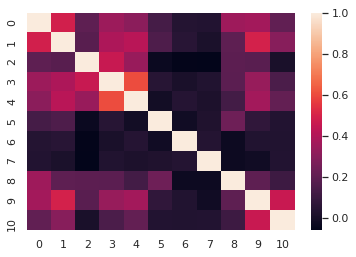

In [105]:
sns.heatmap(pd.DataFrame(proba_matrix.T).corr())

In [90]:
X_val

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,ticker,corn_date,profit,profit_abs
0,0.077103,0.904606,0.780060,0.949487,0.219940,0.180523,0.008859,0.982691,0.961667,0.981336,...,0.980005,0.791168,0.001204,0.014347,11.820,-0.005753,AFKS,2019-07-22,-0.007866,-1388.121856
1,0.074025,0.913466,0.782378,0.956443,0.217622,0.188970,0.006731,0.981667,0.962473,0.982158,...,0.978018,0.791171,0.006670,0.004321,11.730,-0.009548,AFKS,2019-07-23,0.010115,2167.445814
2,0.073529,0.916355,0.782378,0.959092,0.217622,0.187811,0.007015,0.985762,0.965465,0.986556,...,0.978018,0.791171,0.007829,0.040531,11.716,-0.000597,AFKS,2019-07-24,-0.005447,-1167.272595
3,0.072730,0.918671,0.782378,0.960583,0.217622,0.186403,0.005865,0.986781,0.973196,0.986808,...,0.973622,0.791171,0.004841,0.039123,11.699,-0.014959,AFKS,2019-07-25,-0.003157,-676.499269
4,0.068125,0.926342,0.785525,0.963564,0.214475,0.175141,0.004873,0.987572,0.979750,0.986808,...,0.969670,0.789858,0.001220,0.037775,11.695,-0.004446,AFKS,2019-07-26,0.000513,85.440875
5,0.047321,0.946922,0.805730,0.966628,0.194270,0.162968,0.006121,0.985108,0.961264,0.984035,...,0.968603,0.819467,NaN,0.001420,11.714,-0.002988,AFKS,2019-07-29,0.008344,1564.495530
6,0.037862,0.954530,0.819725,0.967787,0.180275,0.164624,0.006413,0.986657,0.962396,0.985194,...,0.969044,0.836114,NaN,0.015305,11.887,-0.000084,AFKS,2019-07-30,-0.003796,-569.380008
7,0.037436,0.955780,0.819725,0.968450,0.180275,0.163630,0.007425,0.984366,0.959168,0.981890,...,0.978148,0.836114,NaN,0.005207,11.875,-0.005137,AFKS,2019-07-31,0.018892,2982.898051
8,0.037403,0.936197,0.800955,0.946759,0.199045,0.177118,0.016462,0.957843,0.925641,0.955013,...,0.983916,0.815029,0.005843,0.020294,12.088,0.005212,AFKS,2019-08-01,0.015683,1960.418223
9,0.028419,0.943499,0.825148,0.948540,0.174852,0.156242,0.017889,0.965267,0.925641,0.960353,...,0.996468,0.826914,0.002714,0.009649,12.129,0.016407,AFKS,2019-08-02,-0.012971,-1768.733359


In [111]:
pred_proba = proba_matrix.sum(axis=0)

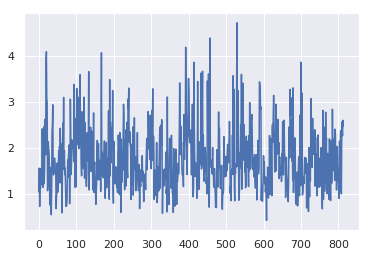

In [109]:
plt.plot(proba_matrix.sum(axis=0))


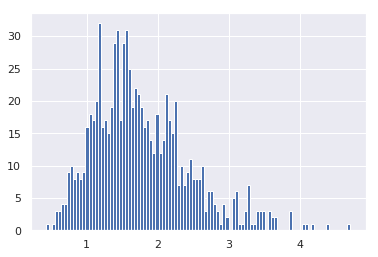

In [115]:
plt.hist(pred_proba, bins=100)
plt.show()

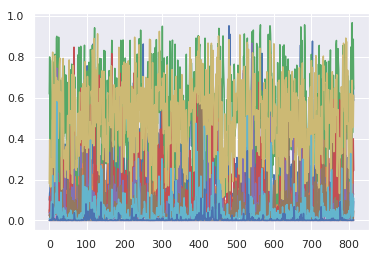

In [107]:
#plt.figure(figsize=(25,15))
for pred in proba_matrix:
    plt.plot(pred)

plt.show()

In [62]:
X_train.shape, X_val.shape

((2040, 76), (660, 78))

In [140]:
df_between(df, corn_date - timedelta(days=31), corn_date).groupby('date')['<OPEN>'].apply(lambda x: single_target_3(np.array([0]+x.tolist()))).values

array([ 0.00462907, -0.00096876,  0.00631068,  0.00810745,  0.01825168,
        0.014242  ,  0.01623832,  0.01103448, -0.0013782 ,  0.00842956,
       -0.00022949,  0.00482759,  0.00114943, -0.00022989, -0.00115929,
        0.01598282,  0.00304771,  0.00537313, -0.01507255,  0.00911854,
        0.00385871])

In [187]:
y_train_profit = calc_target(y_train_series, single_profit_2) 
y_val_profit = calc_target(y_val_series, single_profit_2)


y_train = calc_target(y_train_series, single_target_5) > 0.01
y_val = calc_target(y_val_series, single_target_5) > 0.01

lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['corn_date', 'ticker'], axis=1), y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [15]:
y_train

array([False, False, False, ..., False, False, False])

In [16]:
lgb.feature_importances_

array([ 56,  47,  24,  82,  12,  88,  62,  60,  34,  77,  35,  63,  84,
        38,  31,  71,  36,  68,  76,  81,  64,  99,  12,  74,  82,  68,
        58,  94,  40,  56,  74,  80,  49,  95,  27, 130,  22,  15,  89,
        97,  74,  69, 113, 107,  87, 100])

In [127]:
lgb.feature_importances_

array([ 50,  40,  14,  58,  10,  45,  28,  23,  27,  55,  17,  64,  47,
        37,  11,  47,   6,  42,  48,  36,  21,  35,   9,  58,  64,  39,
        34,  38,   8,  63,  60,  49,  35,  46,  12,  80,  14,  16,  68,
        62,  64,  48,  84,  63,  54, 103,  58,  28,  33,  49,   9,   0,
         5,   9,  53,  56,  62,  50,  43,  50,  29,  61,  53,  30,  40,
        44,  36,  24,  43,  51,  29,  36,  57,  30])

In [31]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,ticker,corn_date
0,0.020548,0.959849,0.926772,0.962205,0.073228,-0.026772,0.005222,0.984692,0.976358,0.982580,...,-0.001298,0.013872,-0.021153,-0.001006,-0.001298,0.013872,-0.021153,-0.001006,PHOR,2019-07-24
1,0.020596,0.960750,0.926772,0.963386,0.073228,-0.031890,0.007173,0.981844,0.972325,0.978521,...,-0.001500,0.013872,-0.021153,-0.001207,-0.001500,0.013872,-0.021153,-0.001207,PHOR,2019-07-23
2,0.019604,0.962383,0.926772,0.964961,0.073228,-0.030709,0.007522,0.984391,0.972325,0.985750,...,-0.001069,0.013872,-0.021153,-0.000804,-0.001069,0.013872,-0.021153,-0.000804,PHOR,2019-07-22
3,0.017545,0.963554,0.926772,0.963780,0.073228,-0.027953,0.006685,0.986032,0.972325,0.987608,...,-0.000422,0.013872,-0.021153,-0.000804,-0.000422,0.013872,-0.021153,-0.000804,PHOR,2019-07-19
4,0.016308,0.964428,0.929134,0.963780,0.070866,-0.031102,0.005196,0.987654,0.974804,0.988021,...,-0.000452,0.013872,-0.021153,-0.000804,-0.000452,0.013872,-0.021153,-0.000804,PHOR,2019-07-18
5,0.015736,0.965553,0.929134,0.964567,0.070866,-0.016929,0.005808,0.984089,0.969199,0.984805,...,0.000322,0.013872,-0.021153,0.000005,0.000322,0.013872,-0.021153,0.000005,PHOR,2019-07-17
6,0.015545,0.966418,0.929134,0.966142,0.070866,-0.012598,0.009369,0.981421,0.963659,0.979584,...,0.000555,0.013872,-0.021153,0.000815,0.000555,0.013872,-0.021153,0.000815,PHOR,2019-07-16
7,0.014877,0.967101,0.929134,0.966142,0.070866,-0.022047,0.017085,0.965785,0.940614,0.960343,...,0.000279,0.013872,-0.021153,-0.000804,0.000279,0.013872,-0.021153,-0.000804,PHOR,2019-07-15
8,0.013582,0.967480,0.929134,0.964567,0.070866,-0.015748,0.018904,0.971673,0.937252,0.969817,...,0.000635,0.013872,-0.021153,0.000005,0.000635,0.013872,-0.021153,0.000005,PHOR,2019-07-12
9,0.012868,0.967855,0.940157,0.964567,0.059843,-0.002362,0.014518,0.980391,0.953535,0.988880,...,0.001407,0.013872,-0.018570,0.000005,0.001407,0.013872,-0.018570,0.000005,PHOR,2019-07-11


In [188]:
del X_val['profit']
del X_val['profit_abs']

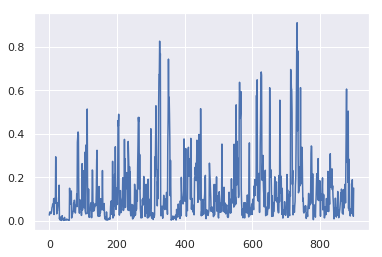

In [189]:
pred_proba = lgb.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
#pred_proba = lgb.predict(X_val.drop(['corn_date', 'ticker'], axis=1))

plt.plot(pred_proba)
plt.show()

# pred_proba_2 = lgb_2.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_2)
# plt.show()

# pred_proba_3 = lgb_3.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_3)

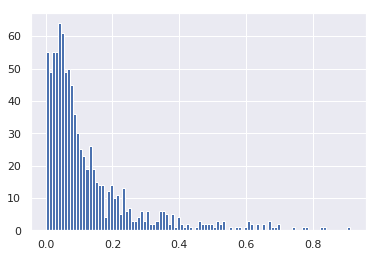

In [190]:
plt.hist(pred_proba, bins=100)
plt.show()

In [199]:
top_idxs = np.where(pred_proba > 0.4)[0]
#top_idxs = np.where(preds.sum(axis=0)/3 > 0.6)[0]


In [788]:
#top_idxs = np.argsort(pred_proba)[::-1][:30]

In [736]:
# X_val['pred'] = pred_proba
# day_thr_df = X_val.groupby('corn_date')['pred'].apply(lambda x: np.sort(x.tolist())[::-1][0]).reset_index().rename({'pred': 'day_thr_pred'}, axis=1)
# X_val = pd.merge(X_val, day_thr_df, on='corn_date', how='left')
# top_idxs = X_val[X_val['pred'] >= X_val['day_thr_pred']].index.values

# del X_val['day_thr_pred']
# del X_val['pred']

In [200]:
top_idxs

array([ 85, 111, 112, 203, 204, 205, 263, 264, 265, 300, 315, 316, 323,
       324, 325, 326, 327, 328, 351, 352, 353, 354, 355, 447, 552, 561,
       562, 563, 564, 565, 566, 612, 614, 624, 625, 626, 627, 651, 652,
       681, 713, 714, 715, 716, 717, 730, 731, 732, 733, 734, 742, 877,
       878, 883])

In [201]:
len(top_idxs)#, len(top_idxs_2), len(top_idxs_3)

54

In [202]:
y_val.mean(), y_val[top_idxs].mean()

(0.14444444444444443, 0.2777777777777778)

In [184]:
y_val.mean(), y_val[top_idxs].mean()

(0.4222222222222222, 0.7272727272727273)

In [195]:
y_train_profit = calc_target(y_train_series, single_profit_2) 
y_val_profit = calc_target(y_val_series, single_profit_2)


In [203]:
X_val['profit'] = y_val_profit
day_cnt_df = X_val.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_val = pd.merge(X_val, day_cnt_df, on='corn_date', how='left')
X_val['volume'] = 3000000 / X_val['cnt_per_day']
X_val['profit_abs'] = X_val['volume'] * X_val['profit']
del X_val['cnt_per_day']
del X_val['volume']

In [238]:
import datetime
datetime.datetime.now().strftime('%H:%M')

'10:03'

In [227]:
X_val.loc[top_idxs]

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,ticker,corn_date,profit,profit_abs
85,0.020632,0.949484,0.895979,0.952506,0.104021,-0.022145,0.014392,0.972710,0.932808,0.970272,...,0.001614,0.003371,1.019346,1.040062,1.007419,1.016766,TATNP,2019-08-19,0.011442,4290.894440
111,0.010831,0.971359,0.941176,0.970647,0.058824,0.017043,0.004123,0.990435,0.983259,0.989446,...,0.000844,0.002851,1.014218,1.026675,1.004348,1.012863,RTKM,2019-08-15,0.006649,3989.165230
112,0.010121,0.971924,0.945319,0.970647,0.054681,0.014440,0.002538,0.994047,0.988294,0.993781,...,0.000844,0.002573,1.013811,1.026675,1.004348,1.012555,RTKM,2019-08-16,-0.001344,-806.156101
203,0.014230,0.969950,0.933801,0.972191,0.066199,-0.034925,0.022336,0.970705,0.933801,0.973221,...,0.001423,0.003215,1.015173,1.036503,1.005888,1.014035,LKOH,2019-08-17,0.035225,17612.621552
204,0.014508,0.969742,0.933801,0.971536,0.066199,-0.037453,0.022336,0.970705,0.933801,0.973221,...,0.001423,0.003240,1.015393,1.036503,1.005888,1.014378,LKOH,2019-08-18,0.035225,15096.532759
205,0.014830,0.969613,0.933801,0.971161,0.066199,-0.034831,0.022336,0.970705,0.933801,0.973221,...,0.001423,0.003266,1.015601,1.036503,1.005888,1.014721,LKOH,2019-08-19,0.035225,13209.466164
263,0.027066,0.947472,0.845376,0.953232,0.154624,-0.081722,0.036427,0.944514,0.874822,0.963326,...,0.001480,0.003787,1.020799,1.063531,1.007626,1.016339,AFKS,2019-08-17,0.000000,0.000000
264,0.027633,0.947697,0.845376,0.954042,0.154624,-0.091674,0.036427,0.944514,0.874822,0.963326,...,0.001480,0.003523,1.020633,1.063531,1.007626,1.015675,AFKS,2019-08-18,0.000000,0.000000
265,0.028254,0.947946,0.845376,0.954689,0.154624,-0.093859,0.036427,0.944514,0.874822,0.963326,...,0.001480,0.003787,1.021081,1.063531,1.007626,1.016339,AFKS,2019-08-19,0.000000,0.000000
300,0.024589,0.943989,0.883508,0.954291,0.116492,-0.111191,0.010258,0.982200,0.951396,0.983644,...,0.000541,0.003989,1.019145,1.037031,1.003256,1.020890,MTLR,2019-07-25,0.012474,37421.027053


In [213]:
X_val.loc[top_idxs].groupby('corn_date')['profit_abs'].sum()

corn_date
2019-07-25    37421.027053
2019-08-01   -44063.143445
2019-08-02    30129.725206
2019-08-04    34311.287916
2019-08-05    34311.287916
2019-08-06    34113.854060
2019-08-07    18041.420492
2019-08-08    15238.436716
2019-08-09   -12061.756192
2019-08-10        0.000000
2019-08-15    -9858.250691
2019-08-16    -6609.194008
2019-08-17     7583.322455
2019-08-18    16883.309447
2019-08-19    22076.338460
2019-08-20     7823.318790
2019-08-21    35295.815321
2019-08-22    30497.592295
Name: profit_abs, dtype: float64

In [214]:
X_val.loc[top_idxs]['profit_abs'].sum()

251134.3917909803

In [ ]:
251134.3917909803
149006.78436374138

In [212]:
78048 / 3000000

0.026016

In [22]:
X_val.loc[top_idxs]['profit_abs'].sum()

-205164.9234591169

In [ ]:
249540.7438308383
238265.8202385087
182758.77619388318
124229.31720323926
91517.8617101984
84287.5011097007

In [ ]:
274337.9430807853
175824.31807198492

In [223]:
X_day = X_val.loc[top_idxs]
X_day = X_day[X_day['corn_date'] == datetime.strptime("20190805", "%Y%m%d").date()]

In [224]:
X_day

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,ticker,corn_date,profit,profit_abs
731,0.018874,0.973902,0.894457,0.980599,0.105543,-0.08847,0.018012,0.975793,0.923218,0.98398,...,0.000974,0.002276,1.013124,1.049826,1.004849,1.011525,MAGN,2019-08-05,0.011437,34311.287916


In [156]:
74939.359122 / 0.02498

2999974.3443554845

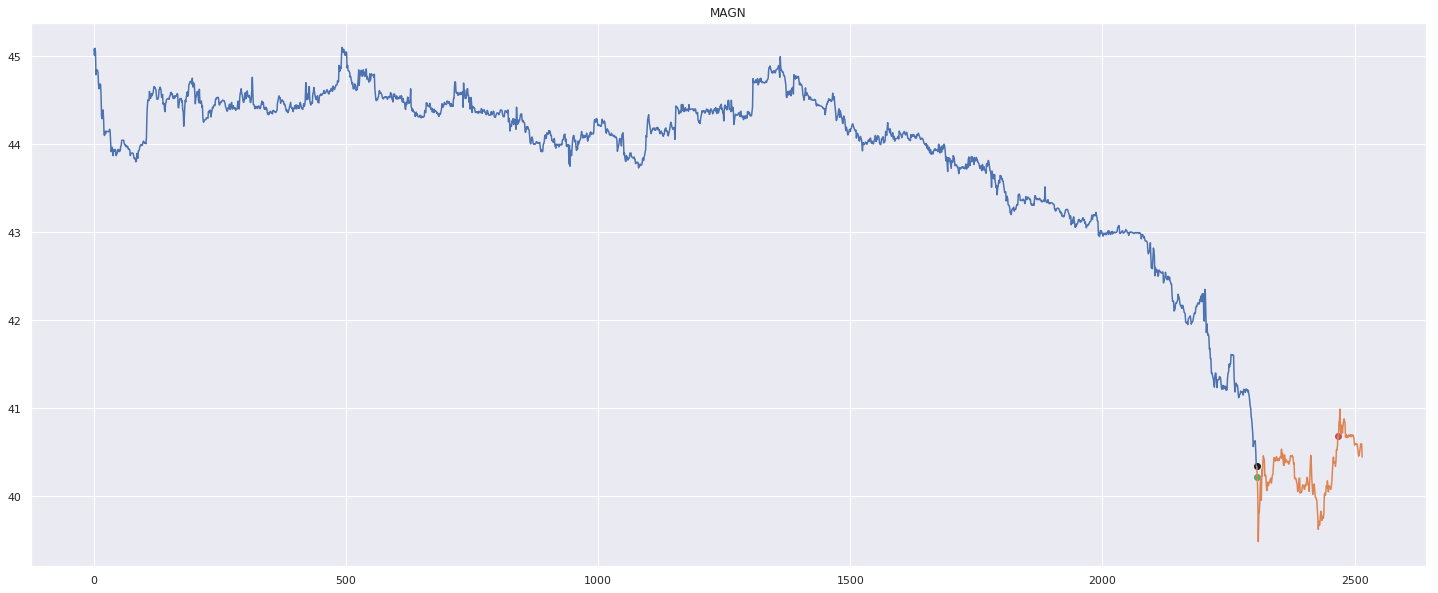

In [226]:
idx = 730
#for idx in top_idxs:
corn_date = X_val.loc[idx]['corn_date']
ticker = X_val.loc[idx]['ticker']

df = ticker2df[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=3))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx = single_profit_2(np.array([0] + list(target_series)), return_idxs=True)
plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx - 1, target_series[buy_idx - 1], color='g')
plt.scatter(len(month_series) + sell_idx - 1, target_series[sell_idx - 1], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')




plt.show()

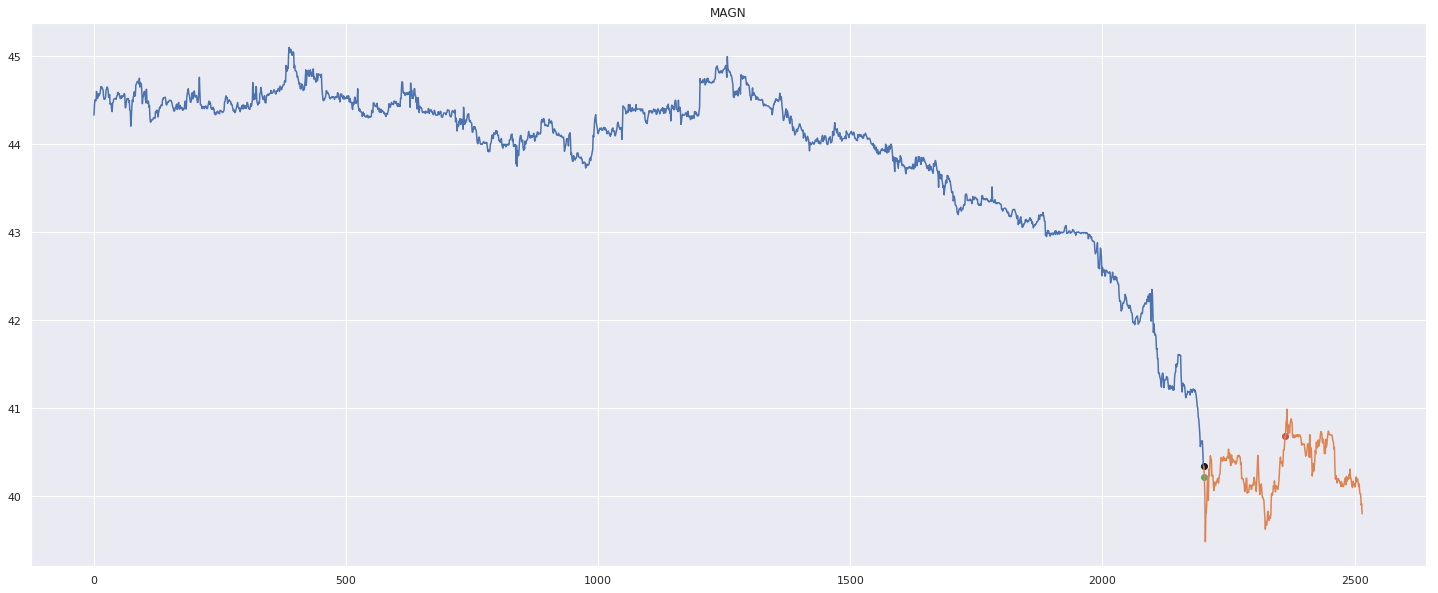

In [225]:
idx = 731
#for idx in top_idxs:
corn_date = X_val.loc[idx]['corn_date']
ticker = X_val.loc[idx]['ticker']

df = ticker2df[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=3))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx = single_profit_2(np.array([0] + list(target_series)), return_idxs=True)
plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx - 1, target_series[buy_idx - 1], color='g')
plt.scatter(len(month_series) + sell_idx - 1, target_series[sell_idx - 1], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')




plt.show()

In [741]:
1

1

# Inference

In [810]:

train_dates = [datetime.today().date() - timedelta(days=x) for x in range(1, 100)]


In [811]:
X_train, y_train_series = all_samples(ticker2df, train_dates)


In [812]:
y_train_profit = calc_target(y_train_series, single_profit_2) 

y_train = calc_target(y_train_series, single_target_3) > 0.01

lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['corn_date', 'ticker'], axis=1), y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [48]:
test_start_day

datetime.date(2019, 7, 4)

In [823]:
load_tickers(data_prefix="data/current", tickers=ibkr_tickers, start_date=datetime.today().date() - timedelta(days=40), end_date=datetime.today().date(), period=3)

 12%|█▏        | 5/41 [00:06<00:45,  1.25s/it]

DSKY


 17%|█▋        | 7/41 [00:07<00:36,  1.07s/it]

FIVE


 61%|██████    | 25/41 [00:29<00:20,  1.28s/it]

RNFT


 76%|███████▌  | 31/41 [00:35<00:12,  1.22s/it]

SFIN


100%|██████████| 41/41 [00:46<00:00,  1.19s/it]


In [824]:
ticker2df_test = load_dfs('data/current', ibkr_tickers)

DSKY
FIVE
RNFT
SFIN


In [825]:
X_test, y_test_series = all_samples(ticker2df_test, [datetime.today().date()], test_mode=True)

In [826]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,ticker,corn_date
0,0.021772,0.968663,0.913214,0.978607,0.086786,-0.075143,0.012023,0.982898,0.954808,0.987320,...,0.917597,NaN,0.996494,0.917597,0.002152,NaN,188.710000,-0.004133,SBERP,2019-08-16
1,0.045381,0.936552,0.848761,0.955551,0.151239,-0.137793,0.017325,0.969955,0.939715,0.967643,...,0.864038,NaN,0.981668,0.864038,0.014610,NaN,38.220000,-0.004710,MAGN,2019-08-16
2,0.016613,0.964002,0.927687,0.961934,0.072313,0.045311,0.006542,0.984266,0.971240,0.983113,...,0.988313,0.977357,0.988313,0.936452,0.005436,0.005520,14924.000000,-0.003618,GMKN,2019-08-16
3,0.017770,0.968264,0.915138,0.966890,0.084862,-0.025503,0.016342,0.956451,0.924236,0.952252,...,0.933996,0.917710,0.994857,0.917710,0.010954,0.005333,1237.800000,0.001616,NVTK,2019-08-16
4,0.036329,0.924107,0.862001,0.909269,0.137999,0.103874,0.012720,0.980907,0.949850,0.983283,...,NaN,0.993030,0.993030,0.864789,NaN,0.003050,864.000000,-0.000579,POLY,2019-08-16
5,0.012289,0.976038,0.950046,0.977716,0.049954,-0.043640,0.003862,0.991805,0.981769,0.992324,...,0.953578,NaN,0.991927,0.953578,0.000932,NaN,256.500000,0.001754,MTSS,2019-08-16
6,0.020613,0.951121,0.868841,0.953637,0.131159,-0.089409,0.030429,0.964018,0.899104,0.973625,...,0.878114,NaN,0.996025,0.878114,0.004095,NaN,10.802000,-0.013609,AFKS,2019-08-16
7,0.032410,0.945021,0.875303,0.953774,0.124697,-0.097484,0.014350,0.969935,0.946774,0.966935,...,0.881601,NaN,0.991183,0.881601,0.002756,NaN,943.000000,-0.006363,CHMF,2019-08-16
8,0.001583,0.993008,0.987165,0.993332,0.012835,0.004167,0.001365,0.997772,0.994975,0.998157,...,0.993647,0.991184,0.998315,0.988072,0.002315,0.000148,5.947000,NaN,CBOM,2019-08-16
9,0.022880,0.946054,0.889132,0.944493,0.110868,0.028409,0.013266,0.974690,0.948177,0.975444,...,0.924968,0.914889,0.987681,0.899211,0.004222,0.005857,632.000000,0.000000,TATNP,2019-08-16


In [745]:
# del X_test['profit']
# del X_test['profit_abs']

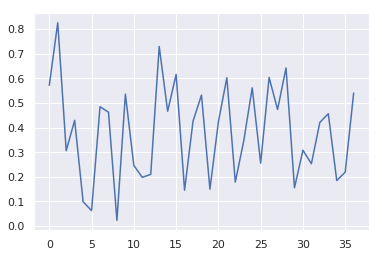

In [827]:
pred_proba = lgb.predict_proba(X_test.drop(['corn_date', 'ticker'], axis=1))[:, 1]
plt.plot(pred_proba)
plt.show()


In [648]:
pred_proba[36]

0.45599322737333703

In [821]:
16990000 * 0.039235

666602.65

In [828]:
top_idxs = np.where(pred_proba > 0.7)[0]
top_idxs

array([ 1, 13])

In [829]:
ticker2price = {}

for ticker in list(X_test.loc[top_idxs, ['ticker', 'corn_date']]['ticker'].values):
    
    df = ticker2df_test[ticker]
    price = df[df['date']==datetime.today().date()]['<OPEN>'].values[0]
    
    ticker2price[ticker] = price


ticker2price

{'MAGN': 38.4, 'TRNFP': 151850.0}

In [762]:
y_test_profit = calc_target(y_test_series, single_profit_2)

In [763]:
X_test['profit'] = y_test_profit
day_cnt_df = X_test.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_test = pd.merge(X_test, day_cnt_df, on='corn_date', how='left')
X_test['volume'] = 3000000 / X_test['cnt_per_day']
X_test['profit_abs'] = X_test['volume'] * X_test['profit']
del X_test['cnt_per_day']
del X_test['volume']

In [570]:
top_idxs

array([24, 36])

In [571]:
X_test.loc[top_idxs, ['ticker', 'corn_date']]

,ticker,corn_date
24,PLZL,2019-08-13
36,RUAL,2019-08-13


In [764]:
X_test.loc[top_idxs, ['ticker', 'corn_date', 'profit', 'profit_abs']]

,ticker,corn_date,profit,profit_abs
1,MAGN,2019-08-14,0.010634,6380.525304
6,AFKS,2019-08-14,-0.047796,-28677.614520
17,YNDX,2019-08-14,-0.017328,-10396.897434
23,ALRS,2019-08-14,-0.024471,-14682.704272
24,PLZL,2019-08-14,0.000000,0.000000


In [573]:
X_test.loc[top_idxs, ['profit']].sum()

profit   -0.014058
dtype: float64

In [765]:
X_test.loc[top_idxs, ['profit_abs']].sum()

profit_abs   -47376.690922
dtype: float64

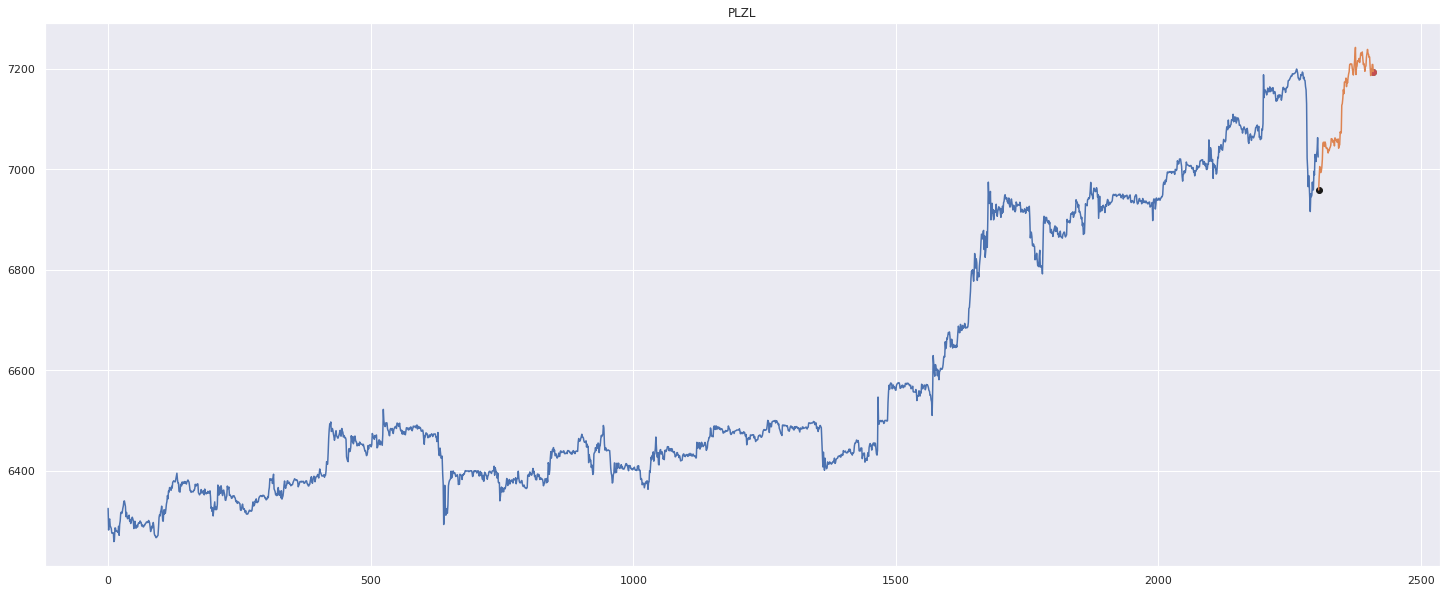

In [772]:
idx = 24
#for idx in top_idxs:
corn_date = X_test.loc[idx]['corn_date']
ticker = X_test.loc[idx]['ticker']

df = ticker2df_test[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=1))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx = single_profit_2(np.array([0] + list(target_series)), return_idxs=True)
plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx - 1, target_series[buy_idx - 1], color='g')
plt.scatter(len(month_series) + sell_idx - 1, target_series[sell_idx - 1], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')

# plt.axhline(y=11.573, linewidth=4, color='g')
# plt.axhline(y=11.675, linewidth=4, color='r')



plt.show()



In [353]:
    series = np.array([0] + list(target_series))
    UPPER_COEF = 1.003
    BUY_HORIZON = 118
    can_buy = (series[2:BUY_HORIZON] <= series[1]*UPPER_COEF).max()

In [354]:
can_buy

False

In [352]:
series[2:BUY_HORIZON] <= series[1]*UPPER_COEF

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [356]:
series

array([  0.  , 223.62, 225.25, 225.69, 225.52, 226.03, 225.69, 224.99,
       225.61, 225.81, 225.4 , 225.53, 225.33, 225.2 , 224.4 , 224.64,
       224.66, 225.03, 224.94, 225.13, 224.96, 225.48, 225.53, 225.64,
       225.49, 225.4 , 224.88, 225.23, 225.08, 225.3 , 225.35, 225.28,
       225.39, 225.35, 225.58, 225.59, 225.8 , 225.69, 225.45, 225.42,
       225.29, 225.27, 225.05, 225.26, 225.49, 225.4 , 225.33, 225.15,
       225.46, 225.44, 226.29, 226.2 , 225.98, 226.14, 226.12, 226.48,
       226.47, 227.21, 227.35, 226.8 , 226.63, 227.17, 227.06, 226.84,
       226.89, 226.69, 226.5 , 226.56, 226.31, 226.54, 226.55, 226.68,
       226.34, 226.4 , 226.55, 226.51, 226.4 , 226.53, 226.63, 226.28,
       226.7 , 226.12, 226.58, 226.69, 227.16, 227.23, 227.27, 227.17,
       226.93, 226.71, 226.93, 226.66, 226.99, 226.94, 226.95, 227.05,
       226.85, 226.95, 226.84, 226.61, 226.47, 226.54, 226.9 , 226.98,
       227.04, 226.76])

In [ ]:
data_prefix='data/train'
start_date=datetime.today().date() - timedelta(days=1)
end_date = datetime.today().date() + timedelta(days=1)

ticker='LKOH'
load_single(ticker, 'data/temp', start_date, end_date, 3)


df = pd.read_csv('data/train/{}.csv'.format(ticker))
df['date'] = df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())

upd_df = pd.read_csv('data/temp/{}.csv'.format(ticker))
upd_df['date'] = upd_df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())